In [18]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np

from pathlib import Path
from dotenv import load_dotenv

import os

from scipy import ndimage
from scipy.signal import find_peaks
from yolov5.utils.plots import Annotator

from utils.preprocess import recovery_rotated_bounding
from utils.yolo import get_teeth_ROI, crop_by_xyxy
from utils.edge import quick_get_roi, integral_intensity_projection, window_avg, get_slope, quick_rotate_and_zooming

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

% matplotlib inline


In [11]:
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')

data_dir = '..' / Path(os.getenv('DATASET_DIR'))

image_number = 1
image_names = list(data_dir.glob('00008554.jpg'))
image_name = image_names[0]


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


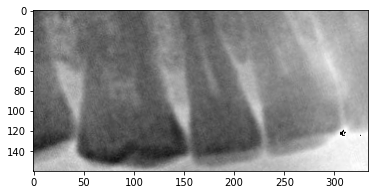

In [12]:
im_g, flag, tooth_position = quick_get_roi(image_name, model, roi_index=0)

source = quick_rotate_and_zooming(im_g, flag=flag, tooth_position=tooth_position)

plt.imshow(1 - source, cmap='gray')
plt.show()


In [13]:
window_size_0_dict = {
    'incisor': 40,
    # TODO test window_size_0 change by angle
    'molar': 70
}

left_margin_0 = 50
tooth_type = 'incisor' if tooth_position == 'middle' else 'molar'
window_size_0 = window_size_0_dict[tooth_type]

_, ver = integral_intensity_projection(source)
ver = window_avg(ver)
ver_slope = get_slope(ver)

integral = ver
slope = ver_slope


[0, 70, 140, 210, 280, 333]


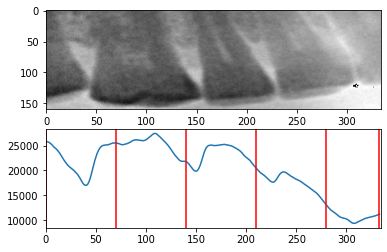

In [63]:
length = slope.shape[0]
negative_slope_index = np.where(slope < 0)[0]
positive_slope_index = np.where(slope > 0)[0]

# find first sign change
left_margin = length
for j in negative_slope_index:
    if slope[j - 1] > 0:
        left_margin = j
        break

# find window size
window_size = []
window_position = [left_margin]
# S = []

i = 0  # window number
j = left_margin
while j < length:
    j += window_size_0

    if j > length - 5:
        break

    # TODO overflow exception
    summation_i = np.sum(slope[j:j + 5]) / 5
    # S.append(S_i)

    # rule a
    if summation_i > 0:
        target_list = negative_slope_index[negative_slope_index > j]
        if len(target_list) == 0:
            break
        j = target_list[0]
    # rule b
    else:
        target_list = positive_slope_index[positive_slope_index < j]
        if len(target_list) == 0:
            break
        j = target_list[-1]

    window_size_current = j - window_position[i]
    if window_size_current < window_size_0:
        window_size_current = window_size_0

    j = window_size_current + window_position[i]

    window_position.append(j)
    window_size.append(window_size_current)

    i += 1

# last window may not include last valley
last_window_size = length - window_position[-1]
if last_window_size > window_size_0 // 2:
    window_position.append(length - 1)
    window_size.append(last_window_size)

# left margin forward too much
if window_position[0] > left_margin_0:
    window_position = np.insert(window_position, 0, 0)
    window_size = np.insert(window_size, 0, window_position[1])

# Plot area
fig, axs = plt.subplots(2, 1)
axs[0].imshow(1 - source, aspect='auto', cmap='gray')

height, width = source.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(ver)
for p in window_position:
    axs[1].axvline(x=p, color='r')
print(window_position)


[40, 140, 150, 227, 308]


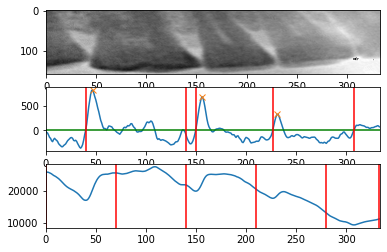

In [74]:
valleys = []
peaks_list = []
for i in range(len(window_size)):
    start = window_position[i]
    end = window_position[i + 1]

    # Peak finding
    has_significant_peak = False

    peaks, properties = find_peaks(integral[start:end], height=0)
    peaks += start
    if len(peaks) > 0:
        peak = peaks[integral[peaks].argmax()]
        if len(peaks) > 1:
            peaks_diff = integral[peaks] - integral[peak]
            has_significant_peak = np.logical_or(peaks_diff < -100, peaks_diff == 0).all()
        else:
            has_significant_peak = True

        # For plot
        if has_significant_peak:
            peaks_list.append(peak)

    if has_significant_peak:
        # TODO check start is necessary
        zero_point_near_peak = np.abs(integral[start:peak]).argmin() + start
        valleys.append(zero_point_near_peak)
    else:
        valley_position = integral[start:end + 1].argmin() + start
        valleys.append(valley_position)

# Plot area
fig, axs = plt.subplots(3, 1)
axs[0].imshow(1 - source, aspect='auto', cmap='gray')

height, width = source.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(slope)
axs[1].plot(peaks_list, ver_slope[peaks_list], "x")
axs[1].axhline(y=0, color='g')
for p in valleys:
    axs[1].axvline(x=p, color='r')

print(valleys)

axs[2].xaxis.set_ticks_position('bottom')
axs[2].set_xlim(xmin=0, xmax=width)
axs[2].plot(ver)
for p in window_position:
    axs[2].axvline(x=p, color='r')


[ 40 150 227 308]


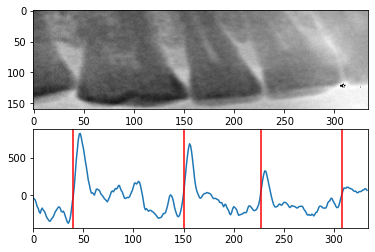

In [75]:
# non valley check
# calculate distance between two valley
valleys = np.array(valleys)
valleys_gap = np.array([valleys[i] - valleys[i - 1] for i in range(1, len(valleys))])
near_valleys = np.where(valleys_gap < window_size_0 // 2)[0]

valleys_mask = np.full(len(valleys), True)
for v_i in near_valleys:
    v_1 = valleys[v_i]
    v_2 = valleys[v_i + 1]

    i_1 = integral[v_1]
    i_2 = integral[v_2]

    if i_1 < i_2:
        valleys_mask[v_i + 1] = False
    else:
        valleys_mask[v_i] = False

valleys = valleys[valleys_mask]

window_position = np.array(window_position)
window_size = np.array(window_size)

# Plot area
fig, axs = plt.subplots(2, 1)
axs[0].imshow(1 - source, aspect='auto', cmap='gray')

height, width = source.shape

axs[1].xaxis.set_ticks_position('bottom')
axs[1].set_xlim(xmin=0, xmax=width)
axs[1].plot(slope)
for p in valleys:
    axs[1].axvline(x=p, color='r')
print(valleys)
